<a href="https://colab.research.google.com/github/PetchMa/DeepSearch/blob/master/SETI_CNNLSTM%5Bembeding%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!apt install ffmpeg
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!pip install pydub
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
!pip install h5py
# !unzip '/content/drive/My Drive/Deeplearning/Information/train.zip' -d '/content/drive/My Drive/Deeplearning/Information/Train_wav'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
--2019-12-30 15:43:47--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.237.57.234, 34.196.154.11, 3.234.122.223, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.237.57.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  53.5MB/s    in 0.2s    

2019-12-30 15:43:48 (53.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es,

In [3]:
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, ConvLSTM2D
from keras.layers.core import Activation, Flatten
import matplotlib.pyplot as plt
from keras.optimizers import SGD,RMSprop,adam
from keras.models import load_model
from sklearn.utils import shuffle
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import os, os.path
import numpy as np
import tempfile
import pydub
import scipy.io.wavfile
from keras.layers import Reshape
from keras import losses
from keras.layers.advanced_activations import LeakyReLU
from pydub import AudioSegment
from scipy.io import wavfile
from keras.layers import Input, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
from keras import backend as K
from keras.layers.convolutional import Convolution1D
from keras.layers import  Conv2D, MaxPool3D, MaxPooling3D, TimeDistributed, Embedding 
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [0]:
# https://keras.io/examples/imdb_cnn_lstm/
def read_mp3(file_path, rate,  as_float = False):
    path, ext = os.path.splitext(file_path)
    assert ext=='.wav'
    mp3 = pydub.AudioSegment.from_file(file_path, format="wav")
    mp3 = mp3.set_frame_rate(rate)
    _, path = tempfile.mkstemp()
    mp3.export(path, format="wav")
    rate, data = scipy.io.wavfile.read(path)
    os.remove(path)
    if as_float:
        data = data/(2**15)
    return data

In [5]:
file_name = '/content/drive/My Drive/data/True_Train_wav'
# Searches for all files
path, dirs, files = next(os.walk(file_name))
# Finds the number of files. 
file_count = len(files)
print('total num of files: ' + str(file_count))

total num of files: 1196


In [6]:
folder = '/content/drive/My Drive/data/True_Train_wav'
rate = 441
time_seconds = 30
length_rate = rate*time_seconds
file_count = file_count-1
print(file_count)
dataset = np.zeros((file_count, length_rate,2), dtype=float)
for i in range(0,file_count):
  if i%100==0:
    print(str(i)+" files have been loaded")
  name = folder+'/'+str(i+1)+'.wav'
  dataset[i][:][:] = read_mp3(name, rate, True)
print("Tensor shape: "+ str(dataset.shape))


1195
0 files have been loaded
100 files have been loaded
200 files have been loaded
300 files have been loaded
400 files have been loaded
500 files have been loaded
600 files have been loaded
700 files have been loaded
800 files have been loaded
900 files have been loaded
1000 files have been loaded
1100 files have been loaded
Tensor shape: (1195, 13230, 2)


In [0]:
# dataset = np.concatenate((dataset, dataset+np.random.rand(dataset.shape[0],dataset.shape[1],dataset.shape[2])*0.1))
# print(dataset.shape)

In [7]:
folder = '/content/drive/My Drive/data/False_Train_wav'
file_name = '/content/drive/My Drive/data/False_Train_wav'
# Searches for all files
path, dirs, files = next(os.walk(file_name))
# Finds the number of files. 
file_count = len(files)
print('total num of files:' + str(file_count))
file_count = file_count -1
fake = np.zeros((file_count, length_rate ,2), dtype=float)
for i in range(0,file_count):
  if i%100==0:
    print(str(i)+" files have been loaded")
  fake[i][:][:] = read_mp3(folder+'/'+str(i+1)+'.wav', rate, True)
fake_add = np.random.rand(400, length_rate,2)
# fake = np.concatenate((fake, fake+np.random.rand(fake.shape[0],fake.shape[1],fake.shape[2])*0.1))
fake = np.concatenate((fake, fake_add))
print("Tensor shape: "+ str(fake.shape))

total num of files:1244
0 files have been loaded
100 files have been loaded
200 files have been loaded
300 files have been loaded
400 files have been loaded
500 files have been loaded
600 files have been loaded
700 files have been loaded
800 files have been loaded
900 files have been loaded
1000 files have been loaded
1100 files have been loaded
1200 files have been loaded
Tensor shape: (1643, 13230, 2)


In [8]:
labeltrue = np.concatenate((np.ones((dataset.shape[0],1),dtype='int64'),np.zeros((dataset.shape[0],1),dtype='int64')), axis=1)
labelfalse = np.concatenate((np.zeros((fake.shape[0],1),dtype='int64'),np.ones((fake.shape[0],1),dtype='int64')), axis=1)
label = np.concatenate((labeltrue, labelfalse))
dataset = np.concatenate((dataset, fake))
print(label.shape)
print(dataset.shape)
print(label[398,:])
print(label[2200,:])

(2838, 2)
(2838, 13230, 2)
[1 0]
[0 1]


In [9]:
dataset,label = shuffle(dataset,label, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=2)
print(X_train.shape)

(2270, 13230, 2)


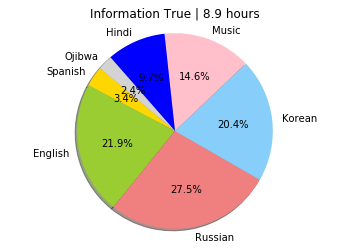

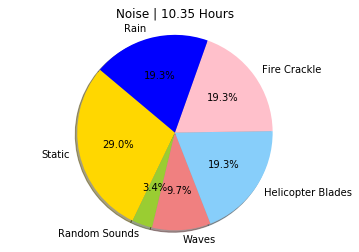

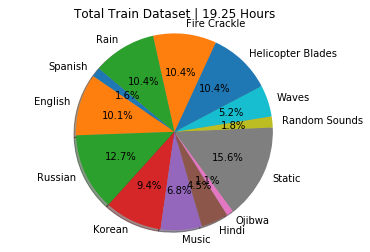

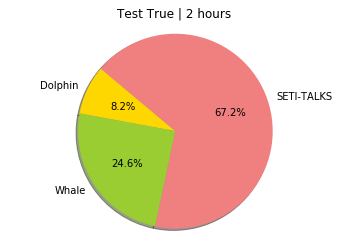

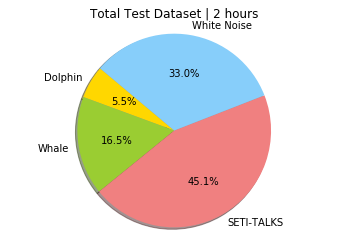

In [10]:
# Data to plot
labels = 'Spanish', 'English', 'Russian', 'Korean','Music', 'Hindi', 'Ojibwa'
sizes = [18/60, 57/60+1, 2+27/60, 1+49/60, 1+18/60,52/60,13/60]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'blue','lightgrey']


# Plot
plt.title('Information True | 8.9 hours', fontdict=None, loc='center', pad=None)
plt.pie(sizes, explode=None, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# ------------------
# Data to plot
labels = 'Static', 'Random Sounds', 'Waves', 'Helicopter Blades','Fire Crackle', 'Rain'
sizes = [3, 21/60, 1, 2,2,2]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'blue','lightgrey']


# Plot
plt.title('Noise | 10.35 Hours', fontdict=None, loc='center', pad=None)
plt.pie(sizes, explode=None, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()
# ------------------
# Data to plot
labels = 'Spanish', 'English', 'Russian', 'Korean','Music', 'Hindi', 'Ojibwa','Static', 'Random Sounds', 'Waves', 'Helicopter Blades','Fire Crackle', 'Rain'
sizes = [18/60, 57/60+1, 2+27/60, 1+49/60, 1+18/60,52/60,13/60,3, 21/60, 1, 2,2,2]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'blue','lightgrey']


# Plot
plt.title('Total Train Dataset | 19.25 Hours', fontdict=None, loc='center', pad=None)
plt.pie(sizes, explode=None, labels=labels, colors=None,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# ------------------
# Data to plot
labels = 'Dolphin', 'Whale', 'SETI-TALKS'
sizes = [1/6, 30/60, 1+22/60]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'blue','lightgrey']


# Plot
plt.title('Test True | 2 hours', fontdict=None, loc='center', pad=None)
plt.pie(sizes, explode=None, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()
# ------------------

# Data to plot
labels = 'Dolphin', 'Whale', 'SETI-TALKS', 'White Noise'
sizes = [1/6, 30/60, 1+22/60,1]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']


# Plot
plt.title('Total Test Dataset | 2 hours', fontdict=None, loc='center', pad=None)
plt.pie(sizes, explode=None, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [11]:
  LR = LeakyReLU(0.3)
  LR.__name__ = 'relu'

In [17]:
# https://stackoverflow.com/questions/46516774/drawing-a-diagram-to-illustrate-this-cnnlstm-network
input_shape = dataset[0].shape
kernel = 100
epoch = 25
learning_rate = 0.1

model = Sequential()

model.add(Convolution1D(32, kernel_size = kernel, strides=1, padding='same', input_shape=input_shape ))
model.add(LR)
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))

model.add(Convolution1D(64, kernel_size = kernel, strides=1, padding='same'))
model.add(LR)
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))

model.add(Convolution1D(128, kernel_size = kernel, strides=1, padding='same'))
model.add(LR)
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))

model.add(Convolution1D(256, kernel_size = kernel, strides=1, padding='same'))
model.add(LR)
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))

model.add(Convolution1D(512, kernel_size = kernel, strides=1, padding='same'))
model.add(LR)
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.5))

# model.add(TimeDistributed(Flatten()))
# model.add(Flatten())
# model.add(Embedding(10000, 64))
# model.add(Dense(30))



model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(CuDNNLSTM(256))
model.add(Dropout(0.5))


model.add(Dense(13230, activation=LR))
model.add(Dropout(0.5))
model.add(Dense(64, activation=LR))
model.add(Dropout(0.5))
model.add(Dense(2 , activation='sigmoid'))

model.summary()
print(learning_rate/epoch)
sgd= SGD(lr=learning_rate, decay = learning_rate/epoch, momentum=0.0, nesterov=False)

model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 13230, 32)         6432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 6615, 32)          0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 6615, 32)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 6615, 64)          204864    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 3307, 64)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 3307, 64)         

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [18]:
batch_size =1
# es_callback = EarlyStopping(monitor='val_loss', mode='min')
mc = ModelCheckpoint('model_8.h5', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train, y_train,  batch_size=batch_size, epochs=25, validation_data=(X_test, y_test), callbacks=[mc])

from keras.models import load_model
# saved_model = load_model('best_model.h5')

Train on 2270 samples, validate on 568 samples
Epoch 1/25
2270/2270 [==============================] - 336s 148ms/step - loss: 0.5915 - acc: 0.6328 - val_loss: 0.6031 - val_acc: 0.5757
Epoch 2/25
2270/2270 [==============================] - 339s 149ms/step - loss: 0.5628 - acc: 0.6581 - val_loss: 0.4652 - val_acc: 0.7923
Epoch 3/25
2270/2270 [==============================] - 335s 148ms/step - loss: 0.3762 - acc: 0.8427 - val_loss: 0.3591 - val_acc: 0.8583
Epoch 4/25
2270/2270 [==============================] - 337s 148ms/step - loss: 0.2934 - acc: 0.8861 - val_loss: 0.2184 - val_acc: 0.9234
Epoch 5/25
2270/2270 [==============================] - 337s 149ms/step - loss: 0.2423 - acc: 0.9101 - val_loss: 0.1714 - val_acc: 0.9419
Epoch 6/25
2270/2270 [==============================] - 339s 149ms/step - loss: 0.2117 - acc: 0.9249 - val_loss: 0.3229 - val_acc: 0.8803
Epoch 7/25
2270/2270 [==============================] - 340s 150ms/step - loss: 0.2193 - acc: 0.9143 - val_loss: 0.1935 - val

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


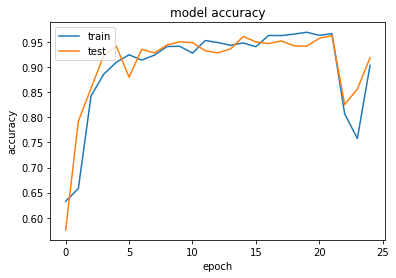

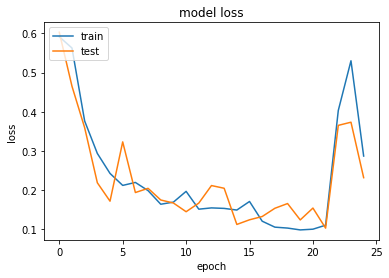

In [19]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [20]:
model = load_model('model_8.h5')
randomnoise = np.random.rand(3,length_rate,2)

print(model.predict(randomnoise))

[[0.03555062 0.9643848 ]
 [0.01849663 0.9817597 ]
 [0.0177546  0.98255783]]


In [21]:
file_name = '/content/drive/My Drive/data/True_Test_wav'
# Searches for all files
path, dirs, files = next(os.walk(file_name))
# Finds the number of files. 
file_count = len(files)
print('total num of files: ' + str(file_count))

folder = '/content/drive/My Drive/data/True_Test_wav'
rate = 441
time_seconds = 30
length_rate = rate*time_seconds
file_count = file_count-1
print(file_count)
test_true = np.zeros((file_count, length_rate,2), dtype=float)
for i in range(0,file_count):
  if i%100==0:
    print(str(i)+" files have been loaded")
  name = folder+'/'+str(i+1)+'.wav'
  test_true[i][:][:] = read_mp3(name, rate, True)
print("Tensor shape: "+ str(test_true.shape))

total num of files: 135
134
0 files have been loaded
100 files have been loaded
Tensor shape: (134, 13230, 2)


In [22]:
file_name = '/content/drive/My Drive/data/False_Test_wav'
# Searches for all files
path, dirs, files = next(os.walk(file_name))
# Finds the number of files. 
file_count = len(files)
print('total num of files: ' + str(file_count))

folder = '/content/drive/My Drive/data/False_Test_wav'
rate = 441
time_seconds = 30
length_rate = rate*time_seconds
file_count = file_count-1
print(file_count)
test_false = np.zeros((file_count, length_rate,2), dtype=float)
for i in range(0,file_count):
  if i%100==0:
    print(str(i)+" files have been loaded")
  name = folder+'/'+str(i+1)+'.wav'
  test_false[i][:][:] = read_mp3(name, rate, True)
print("Tensor shape: "+ str(test_false.shape))
# test_false = np.random.rand(134,length_rate,2)

total num of files: 120
119
0 files have been loaded
100 files have been loaded
Tensor shape: (119, 13230, 2)


In [23]:
labeltrue_test = np.concatenate((np.ones((test_true.shape[0],1),dtype='int64'),np.zeros((test_true.shape[0],1),dtype='int64')), axis=1)
print(labeltrue_test.shape)
labelfalse_test = np.concatenate((np.zeros((test_false.shape[0],1),dtype='int64'),np.ones((test_false.shape[0],1),dtype='int64')), axis=1)
print(labelfalse_test.shape)
test_label = np.concatenate((labeltrue_test, labelfalse_test))
test = np.concatenate((test_true, test_false))

(134, 2)
(119, 2)


In [0]:
print(test_label[183])
print(test_label[184])

[0 1]
[0 1]


In [0]:

# test,test_label = shuffle(test,test_label, random_state=2)

In [24]:
print(model.predict(test_false))
print('------------')
print(model.predict(test_true))
print('--------------')
print(np.argmax(model.predict(test_false), axis=1))
print(np.argmax(model.predict(test_true), axis=1))

[[0.01205    0.9880159 ]
 [0.01394895 0.9860642 ]
 [0.01448062 0.9855324 ]
 [0.01371655 0.9863061 ]
 [0.01263773 0.987425  ]
 [0.01391041 0.98610497]
 [0.01447478 0.9855505 ]
 [0.0159288  0.98405784]
 [0.01277944 0.9872713 ]
 [0.01485437 0.98514235]
 [0.0146805  0.9853523 ]
 [0.01208007 0.9879657 ]
 [0.01285309 0.9871799 ]
 [0.01290965 0.9870998 ]
 [0.02180475 0.9780128 ]
 [0.0133923  0.9866346 ]
 [0.01417956 0.98581505]
 [0.01335409 0.98668194]
 [0.01223391 0.9878332 ]
 [0.01627785 0.9836577 ]
 [0.01596746 0.9840718 ]
 [0.01393902 0.9860925 ]
 [0.0156759  0.9843261 ]
 [0.01360336 0.986427  ]
 [0.01324075 0.9867585 ]
 [0.01405761 0.9859316 ]
 [0.0266802  0.97291946]
 [0.01252517 0.9875275 ]
 [0.0130586  0.9869789 ]
 [0.01439393 0.9856394 ]
 [0.02202001 0.9777021 ]
 [0.01303744 0.9870048 ]
 [0.01472086 0.9852974 ]
 [0.01553822 0.9844655 ]
 [0.01372838 0.9862819 ]
 [0.02687517 0.9726925 ]
 [0.0142349  0.985803  ]
 [0.01203871 0.9880145 ]
 [0.02179313 0.97806525]
 [0.01374698 0.98628384]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

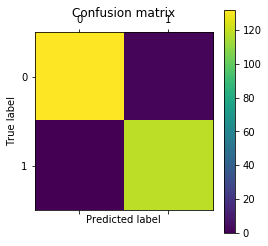

In [25]:
print(np.argmax(test_label, axis=1))
print(np.argmax(model.predict(test), axis=1))
cm=confusion_matrix(np.argmax(test_label, axis=1), np.argmax(model.predict(test), axis=1))
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()